In [395]:
import zipfile
import numpy as np
import pandas as pd
import gzip
import shutil
from Bio import SeqIO
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
from matplotlib.pyplot import figure
import pickle
from itertools import chain
from Bio.Align import PairwiseAligner
aligner = PairwiseAligner()
#from Bio.Align import substitution_matrices
#alignerPROT = PairwiseAligner()
#alignerPROT.substitution_matrix = substitution_matrices.load("BLOSUM62")
from scipy.spatial.distance import hamming
from scipy import stats
import re

In [4]:
with open('./../PSICUBE_dict.pickle', 'rb') as handle:
    PSICUBE_dict = pickle.load(handle)

In [5]:
#Import GENEs
MART111fna_file="./mart111fasta_export.txt"

In [3]:

with gzip.open(f"{MART111fna_file}.gz", 'rb') as f_in:
    with open(MART111fna_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [6]:
##parce to dictionary
input_file = open(MART111fna_file)
MART111fna_orig = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))

In [33]:
#with open('./MART111fna_orig.pickle', 'wb') as handle:
#    pickle.dump(MART111fna_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
list(MART111fna_orig.keys())[0]

'ENSG00000000005|ENST00000373031;ENST00000485971|TNMD|protein_coding|protein_coding;protein_coding_CDS_not_defined'

In [7]:
MART111fna_protcodgeneid=[key.split("|")[0] for key in MART111fna_orig.keys() if key.split("|")[3]=="protein_coding"]
MART111fna_psdgtrxid=[key.split("|")[1].split(";") for key in MART111fna_orig.keys() if "pseudogene" in key.split("|")[3]]
MART111fna_psdgtrxid=list(chain.from_iterable(MART111fna_psdgtrxid))

In [8]:
len(MART111fna_psdgtrxid),len(MART111fna_protcodgeneid)

(17313, 23214)

In [9]:
#Define pseudogene - psrental GENE pairs, filter out version incompatibilies and incompleat pairs.
pairs_gene=[(k.split("_")[0],k.split("_")[1]) for k in PSICUBE_dict.keys()]
PSIfilt_pairs=pairs_gene.copy()
#MART111fna_psdgtrxid_psi=MART111fna_psdgtrxid.copy()
#MART111fna_protcodgeneid_psi=MART111fna_protcodgeneid.copy()
for pair in pairs_gene:
    if pair[0] not in MART111fna_psdgtrxid or pair[1] not in MART111fna_protcodgeneid:
        #MART111fna_psdgtrxid_psi.remove(pair[0])
        #MART111fna_protcodgeneid_psi.remove(pair[1])
        PSIfilt_pairs.remove(pair)

In [35]:
#with open('./PSIfilt_pairs.pkl', 'wb') as f:
#    pickle.dump(PSIfilt_pairs, f)

In [10]:
len(pairs_gene),len(PSIfilt_pairs)

(10371, 9484)

In [11]:
PSIfilt_psdgtrx=[pair[0] for pair in PSIfilt_pairs]
PSIfilt_pggene=[pair[1] for pair in PSIfilt_pairs]

In [45]:
#a=["1.4","2.5","3.6"]
#b=["4","6"]
#{e:i for i in a for e in i.split(".") if e in b}

{'4': '1.4', '6': '3.6'}

In [12]:
PSIfilt_psdggene_map={trx:key for key in  MART111fna_orig.keys() for trx in key.split("|")[1].split(";") if trx in PSIfilt_psdgtrx}

In [13]:
PSIfilt_pggene_map={key.split("|")[0]:key for key in  MART111fna_orig.keys() if key.split("|")[0] in PSIfilt_pggene}

In [34]:
#with open('./PSIfilt_psdggene_map.pickle', 'wb') as handle:
#    pickle.dump(PSIfilt_psdggene_map, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('./PSIfilt_pggene_map.pickle', 'wb') as handle:
#    pickle.dump(PSIfilt_pggene_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
print(len(set(PSIfilt_psdggene_map.keys())),len(set(PSIfilt_pggene_map.keys())))
print(len(set(PSIfilt_psdgtrx)),len(set(PSIfilt_pggene)))

9484 3366
9484 3366


In [15]:
def end_of_loop():
     raise StopIteration
def align_start(seq):
    count=[]
    try:
        [end_of_loop() if len(count)>0 else count.append(i) for c,i in zip(seq,range(0,len(seq))) if c=="A" or c=="T" or c=="G" or c=="C"]
    except StopIteration:
        return count[0]
def align_end(seq):
    seq=seq[::-1]
    count=[]
    try:
        [end_of_loop() if len(count)>0 else count.append(i) for c,i in zip(seq,range(0,len(seq))) if c=="A" or c=="T" or c=="G" or c=="C"]
    except StopIteration:
        return len(seq)-count[0]

In [ ]:
MART111fna_align_psipairs_dict={}
#MART111fna_seqpsipairs_ident=[]
for pair in PSIfilt_pairs:
    psdgkey=PSIfilt_psdggene_map[pair[0]]
    protcodkey=PSIfilt_pggene_map[pair[1]]
    psdg_seq=str(MART111fna_orig[psdgkey].seq)
    pg_seq=str(MART111fna_orig[protcodkey].seq)
    alignments = aligner.align(psdg_seq, pg_seq)
    alignment = alignments[0]
    lines = str(alignment).split("\n")
    psdg_alg=lines[0]
    pg_alg=lines[2] 
    MART111fna_align_psipairs_dict[pair]={}
    MART111fna_align_psipairs_dict[pair]["psdg_align"]=psdg_alg
    MART111fna_align_psipairs_dict[pair]["pg_align"]=pg_alg
    #stind=align_start(psdg_alg)
    #endind=align_end(psdg_alg)
    #MART111fna_seqpsipairs_ident.append((1-hamming(list(psdg_alg[stind:endind]),list(pg_alg[stind:endind]))))

In [ ]:
#with open('./MART111fna_align_psipairs_dict.pickle', 'wb') as handle:
#    pickle.dump(MART111fna_align_psipairs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('./MART111fna_seqpsipairs_ident.pkl', 'wb') as f:
    pickle.dump(MART111fna_seqpsipairs_ident, f)

In [69]:
#Import GENEs
MART95fna_file="./mart95fasta_export.txt"

In [70]:
with gzip.open(f"{MART95fna_file}.gz", 'rb') as f_in:
    with open(MART95fna_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [72]:
##parce to dictionary
input_file = open(MART95fna_file)
MART95fna_orig = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))

In [73]:
#with open('./MART95fna_orig.pickle', 'wb') as handle:
#    pickle.dump(MART95fna_orig, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [76]:
list(MART95fna_orig.keys())[0]

'ENSG00000000005|ENST00000373031;ENST00000485971|TNMD|protein_coding|protein_coding;processed_transcript'

In [84]:
MART95fna_protcodgeneid=[key.split("|")[0] for key in MART95fna_orig.keys() if key.split("|")[3]=="protein_coding"]
MART95fna_psdgtrxid=[key.split("|")[1].split(";") for key in MART95fna_orig.keys() if "pseudogene" in key.split("|")[3]]
MART95fna_psdgtrxid=list(chain.from_iterable(MART95fna_psdgtrxid))

In [86]:
#Define pseudogene - psrental GENE pairs, filter out version incompatibilies and incompleat pairs.
pairs_gene=[(k.split("_")[0],k.split("_")[1]) for k in PSICUBE_dict.keys()]
PSIfilt95_pairs=pairs_gene.copy()
for pair in pairs_gene:
    if pair[0] not in MART95fna_psdgtrxid or pair[1] not in MART95fna_protcodgeneid:
        PSIfilt95_pairs.remove(pair)

In [116]:
len(PSIfilt95_pairs)

9547

In [114]:
MART95fna_protcodtrxid=[key.split("|")[1].split(";") for key in MART95fna_orig.keys()  if key.split("|")[3]=="protein_coding"]
MART95fna_protcodtrxid=list(chain.from_iterable(MART95fna_protcodtrxid))

In [115]:
#Define pseudogene - psrental GENE pairs, filter out version incompatibilies and incompleat pairs.
#pairs_trx=[(k.split("_")[0],k.split("_")[2]) for k in PSICUBE_dict.keys()]
#PSIfilt95_pairstrx=pairs_trx.copy()
#for pair in pairs_trx:
#    if pair[0] not in MART95fna_psdgtrxid or pair[1] not in MART95fna_protcodtrxid:
#        PSIfilt95_pairstrx.remove(pair)

In [117]:
len(PSIfilt95_pairstrx)

8783

In [77]:
MART95_acss={}
for key in MART95fna_orig.keys():
    gene=key.split("|")[0]
    trxlist=key.split("|")[1].split(";")
    for trx in trxlist:
        MART95_acss[trx]=gene

#protein

In [278]:
with open(f'./MS3up1_psdgU.pkl','rb') as handle:
    MS3up1_psdgU= pickle.load(handle)
with open(f'./MS2p_psdgU.pkl','rb') as handle:
    MS2p_psdgU= pickle.load(handle)

In [287]:
MSall_psdgU=list(set(MS3up1_psdgU+MS2p_psdgU))

In [288]:
MSall_psdgUtrx=[trx for gene in MSall_psdgU for trx in MART95_acss.keys() if gene==MART95_acss[trx]] #all trx for each psdg

In [284]:
psi_psdgtrx=[k.split("_")[0] for k in PSICUBE_dict.keys()]

In [289]:
MSall_psdgUtrx_psi=[trx for trx in MSall_psdgUtrx if trx in psi_psdgtrx]

In [290]:
len(MSall_psdgUtrx_psi)

1279

In [291]:
#MSall_psdgUgene_psi=[MART95_acss[trx] for trx in MSall_psdgUtrx_psi]

In [74]:
#Openprot pseudogenic proteins filtered by overlap with psiCube (by pseudogene transcript accession) and by  longest transcript (acording to Openprot).
#Note, if pseudogene transcript accession was present in Openprot, but coresponding parental gene transcript accession was absent (and visa versa), the pair was not included in .pkl.
#OP_df_altprot_ms0_psdg_psicube_lngstorf=pd.read_pickle("./OP16_df_altprot_ms0_psdg_psicube_lngstorf.pkl")
#Openprot reference proteins filtered by overlap with psiCube (by parental gene transcript accession) and by  longest transcript (acording to Openprot).
#Note, if pseudogene transcript accession was present in Openprot, but coresponding parental gene transcript accession was absent (and visa versa), the pair was not included in .pkl.
#OP_df_refprot_ms0_psicube_lngstorf=pd.read_pickle("./OP16_df_refprot_ms0_psicube_lngstorf.pkl")
#Filtered (above) pseudogenic proteins sequence (SeqIO dictionary).
#with open(f'./OP16fasta_psdgpsicube_lngstorf.pickle','rb') as handle:
#    OPfasta_psdgpsicube_lngstorf= pickle.load(handle)
#Filtered (above) reference proteins sequence (SeqIO dictionary).
#with open(f'./OP16fasta_refprotpsicube_lngstorf.pickle','rb') as handle:
#    OPfasta_refprotpsicube_lngstorf= pickle.load(handle)

In [293]:
OP16_df_altprot_ms0_psdg_psicube=pd.read_pickle("OP16_df_altprot_ms0_psdg_psicube.pkl")
OP16_df_refprot_ms0_psicube=pd.read_pickle("OP16_df_refprot_ms0_psicube.pkl")
with open(f'./OP16fasta_orig.pickle','rb') as handle:
    OPfasta_orig= pickle.load(handle)

In [294]:
OP16_df_refprot_ms0_psicube["genestableid"]=[MART95_acss[trx] for trx in list(OP16_df_refprot_ms0_psicube['trxstableid'])]
OP16_df_altprot_ms0_psdg_psicube["genestableid"]=[MART95_acss[trx] for trx in list(OP16_df_altprot_ms0_psdg_psicube['trxstableid'])]

In [307]:
#only stranslated psdg
OP16_df_altprot_ms0_psdg_psicube_MSalltrx=OP16_df_altprot_ms0_psdg_psicube.loc[OP16_df_altprot_ms0_psdg_psicube["trxstableid"].isin(MSall_psdgUtrx_psi),]

In [308]:
#at least MS score 2
OP16_df_altprot_ms0_psdg_psicube_MSalltrx_2p=OP16_df_altprot_ms0_psdg_psicube_MSalltrx.loc[OP16_df_altprot_ms0_psdg_psicube_MSalltrx["MS score"]>=2,]

In [312]:
#increas search space by taking genes
#PSIfilt95_pairsgenes=[]
#for pair in PSIfilt95_pairs:
#    if pair[0] in list(OP16_df_altprot_ms0_psdg_psicube_MSalltrx_2p["trxstableid"]):
#        PSIfilt95_pairsgenes.append(tuple([MART95_acss[pair[0]],pair[1]]))

In [326]:
#filter within trx
PSIfilt95_pairstrx_protacc=[]
PSIfilt95_pairstrx_real=[]
#some pairs may be absent not only in version 95 in general but also in Openprot, as gene/trx with ORF<30 aa are not included in it, or may not contain ORF at all
for pair in PSIfilt95_pairstrx:
    psdg_protacc=OP16_df_altprot_ms0_psdg_psicube_MSalltrx_2p.loc[OP16_df_altprot_ms0_psdg_psicube_MSalltrx_2p['trxstableid']==pair[0],'protein accession numbers'].values
    pg_protacc=OP16_df_refprot_ms0_psicube.loc[OP16_df_refprot_ms0_psicube['trxstableid']==pair[1],'protein accession numbers'].values
    if len(psdg_protacc)==0 or len(pg_protacc)==0: #as df previously was filterd on incomplete pairs, just skip them
        next
    else:
        PSIfilt95_pairstrx_protacc.append(tuple([psdg_protacc,pg_protacc]))
        PSIfilt95_pairstrx_real.append(pair)

In [322]:
len(PSIfilt95_pairstrx_protacc)

682

In [173]:
#filter the longest orf for each gene
#PSIfilt95_pairsgenes_protacc_maxlen=[]
#for pairpep in PSIfilt95_pairstrx_protacc:
#    peps_psdg=pairpep[0]
#    peps_pg=pairpep[1]
#    psdg_maxind=OP16_df_altprot_ms0_psdg_psicube.loc[OP16_df_altprot_ms0_psdg_psicube['protein accession numbers'].isin(peps_psdg),'protein length (a.a.)'].idxmax()
#    peps_psdg_max=OP16_df_altprot_ms0_psdg_psicube.loc[psdg_maxind,'protein accession numbers']
#    pg_maxind=OP16_df_refprot_ms0_psicube.loc[OP16_df_refprot_ms0_psicube['protein accession numbers'].isin(peps_pg),'protein length (a.a.)'].idxmax()
#    peps_pg_max=OP16_df_refprot_ms0_psicube.loc[pg_maxind,'protein accession numbers']
#    PSIfilt95_pairsgenes_protacc_maxlen.append(tuple([peps_psdg_max,peps_pg_max]))

In [264]:
#pepspsdg=[pep[0] for pep in PSIfilt95_pairsgenes_protacc_maxlen]

In [267]:
#OP16_df_altprot_ms0_psdg_psicube.loc[OP16_df_altprot_ms0_psdg_psicube['protein accession numbers'].isin(pepspsdg[0:10]),]

In [323]:
#OP16_df_refprot_ms0_psicube["frame"].value_counts()

In [324]:
#len(OP_psdgpsicube_maxlen_protacc)

In [336]:
#creat all combinations of peptides to filter after
ProtAcc_dict={}
for peppair,trxpair in zip(PSIfilt95_pairstrx_protacc,PSIfilt95_pairstrx_real):
    peppsdglist=list(peppair[0])
    peppglist=list(peppair[1])
    for i in range(len(peppsdglist)):
        for j in range(len(peppglist)):
            ProtAcc_dict[(peppsdglist[i], peppglist[j])]=trxpair

In [337]:
len(ProtAcc_dict)

862

In [341]:
#Select only keys with pseudogenic proteins.
OP_psdgpsicube_allprotacc=[psdgprotacc for pair in PSIfilt95_pairstrx_protacc for psdgprotacc in pair[0]]
OPfasta_psdgpsicube_allprotacc={}
nokey=0
nokeylist=[]
for ip in OP_psdgpsicube_allprotacc:
    key=f"{ip}|TX=9606"
    if key in OPfasta_orig.keys():
        OPfasta_psdgpsicube_allprotacc[key]=OPfasta_orig[key]
    else:
        nokey+=1
        nokeylist.append(ip)
print(nokey,len(OPfasta_psdgpsicube_allprotacc.keys()),len(set(OP_psdgpsicube_allprotacc)))

0 856 856


In [343]:
#stillnokey=0
#for ip in nokeylist:
#    otherips=list(OP16_df_altprot_ms0_psdg_psicube.loc[OP16_df_altprot_ms0_psdg_psicube["protein accession numbers"]==ip,"protein accession (others)"])[0].split(";")
#    stillnokey+=1
#    for ip2 in otherips:
#        key=f"{ip2}|TX=9606"
#        if key in OPfasta_orig.keys():
#            OPfasta_psdgpsicube_maxlen[key]=OPfasta_orig[key]
#            PSIfilt95_pairsgenes_protacc_maxlen_dkey=[tuple([ip2,pair[1]]) if pair[0]==ip else pair for pair in PSIfilt95_pairsgenes_protacc_maxlen_dkey] ##substitut key 
#            stillnokey-=1
#print(stillnokey,len(OPfasta_psdgpsicube_maxlen.keys()))

In [351]:
#with open(f'./OP16fasta_psdgpsicube_allprotacc.pickle','wb') as handle:
    pickle.dump(OPfasta_psdgpsicube_allprotacc, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

In [372]:
#Select only keys with canonical proteins.
OP_pgpsicube_allprotacc=[pgprotacc for pair in PSIfilt95_pairstrx_protacc for pgprotacc in pair[1]]
OPfasta_pgpsicube_allprotacc={}
nokey=0
nokeylist=[]
for ip in OP_pgpsicube_allprotacc:
    key=f"{ip}|TX=9606"
    if key in OPfasta_orig.keys():
        OPfasta_pgpsicube_allprotacc[key]=OPfasta_orig[key]
    else:
        nokey+=1
        nokeylist.append(ip)
print(nokey,len(OPfasta_pgpsicube_allprotacc.keys()),len(set(OP_pgpsicube_allprotacc)))

679 6 457


In [373]:
ProtAcc_dict_dkey=ProtAcc_dict.copy()

In [374]:
#Some keys are absent because proteins have several protein accessions. 
#Other protein accessions are writen in "protein accession (others)" column. 
#Find the right accession and add it to dictionary.
stillnokey=0
for ip in nokeylist:
    otherips=list(OP16_df_refprot_ms0_psicube.loc[OP16_df_refprot_ms0_psicube["protein accession numbers"]==ip,"protein accession (others)"])[0].split(";")
    stillnokey+=1
    for ip2 in otherips:
        key=f"{ip2}|TX=9606"
        if key in OPfasta_orig.keys():
            OPfasta_pgpsicube_allprotacc[key]=OPfasta_orig[key]
            #ProtAcc_dict_dkey={tuple([pair[0],ip2]):ProtAcc_dict[pair] if pair[1]==ip else pair:ProtAcc_dict[pair] for pair in ProtAcc_dict.keys()}##substitut key 
            ProtAcc_dict_dkey={ (tuple([pair[0],ip2]) if pair[1]==ip else pair):ProtAcc_dict_dkey[pair] for pair in ProtAcc_dict_dkey.keys() }
            #PSIfilt95_pairsgenes_protacc_maxlen_dkey=[tuple([pair[0],ip2]) if pair[1]==ip else pair for pair in PSIfilt95_pairsgenes_protacc_maxlen_dkey] 
            stillnokey-=1
print(stillnokey,len(OPfasta_pgpsicube_allprotacc.keys()))

0 437


In [377]:
#with open(f'./OP16fasta_pgpsicube_allprotacc.pickle','wb') as handle:
    pickle.dump(OPfasta_pgpsicube_allprotacc, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

In [376]:
#with open("./ProtAcc_dict_dkey.pkl","wb") as f:
    pickle.dump(ProtAcc_dict_dkey,f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close

In [418]:
OPpsi_pepseqalignd_ms2p={}
for pair in ProtAcc_dict_dkey.keys():
    pep_psdgkey=f"{pair[0]}|TX=9606"
    pep_pgkey=f"{pair[1]}|TX=9606"
    pep_psdg_seq=str(OPfasta_psdgpsicube_allprotacc[pep_psdgkey].seq)
    pep_pg_seq=str(OPfasta_pgpsicube_allprotacc[pep_pgkey].seq)
    #Selenocysteine(S) to cysteine(C) as it is absent in substitution matrix
    if "U" in pep_psdg_seq:
        pep_psdg_seq=pep_psdg_seq.replace("U","C")
    if "U" in pep_pg_seq:
        pep_pg_seq=pep_pg_seq.replace("U","C")
    alignments = alignerPROT.align(pep_psdg_seq, pep_pg_seq)
    alignment = alignments[0]
    lines = str(alignment).split("\n")
    psdg_alg=lines[0]
    pg_alg=lines[2] 
    OPpsi_pepseqalignd_ms2p[pair]={}
    OPpsi_pepseqalignd_ms2p[pair]["psdg_align"]=psdg_alg
    OPpsi_pepseqalignd_ms2p[pair]["pg_align"]=pg_alg
    stind=align_start(psdg_alg)
    endind=align_end(psdg_alg)
    OPpsi_pepseqalignd_ms2p[pair]["ident"]=(1-hamming(list(psdg_alg[stind:endind]),list(pg_alg[stind:endind])))

In [419]:
#with open(f'./OPpsi_pepseqalignd_ms2p.pickle','wb') as handle:
    pickle.dump(OPpsi_pepseqalignd_ms2p, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

In [420]:
len(OPpsi_pepseqalignd_ms2p.keys())

862

In [423]:
len(OPpsi_pepseqalignd_ms2p_maxident)

682

In [437]:
OPpsi_pep_ident1=[]
for key in OPpsi_pepseqalignd_ms2p_maxident.keys():
    OPpsi_pep_ident1.append(OPpsi_pepseqalignd_ms2p_maxident[key]["ident"])

In [438]:
OPpsi_pep_ident2=[]
for key in OPpsi_pepseqalignd_ms2p.keys():
    OPpsi_pep_ident2.append(OPpsi_pepseqalignd_ms2p[key]["ident"])

In [440]:
np.mean(OPpsi_pep_ident1),np.mean(OPpsi_pep_ident2)

(0.43193196482966273, 0.3841322682695824)

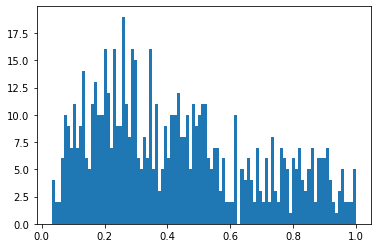

In [441]:
plt.hist(OPpsi_pep_ident1,bins=100);

In [ ]:
#code ...

In [476]:
with open(f'./OP16psi_pepseqalignd_ms2p_blast.pickle','rb') as handle:
    OPpsi_pepseqalignd_ms2p_blast= pickle.load(handle)

In [477]:
nohit=0
for key in OPpsi_pepseqalignd_ms2p_blast.keys():
    if len(OPpsi_pepseqalignd_ms2p_blast[key])==0:
        nohit+=1
        OPpsi_pepseqalignd_ms2p_blast[key]["ident"]=0#np.nan
    else:
        seq=OPpsi_pepseqalignd_ms2p_blast[key]["match"]
        OPpsi_pepseqalignd_ms2p_blast[key]["ident"]=len(re.findall('[A-Z]', seq))/len(seq)

In [478]:
nohit

27

In [479]:
OPpsi_pepseqalignd_ms2p_blast_maxident={}
for trxpair in PSIfilt95_pairstrx_real:
    peppairs_list=[]
    for peppairs in ProtAcc_dict_dkey.keys():
        if ProtAcc_dict_dkey[peppairs]==trxpair:
            peppairs_list.append(peppairs)
    ident_list=[]
    for peppairs in peppairs_list:
        ident_list.append(OPpsi_pepseqalignd_ms2p_blast[peppairs]["ident"])
    #if np.sum(ident_list)==np.nan
    peppairs_maxident=peppairs_list[ident_list.index(np.max(ident_list))]
    OPpsi_pepseqalignd_ms2p_blast_maxident[peppairs_maxident]=OPpsi_pepseqalignd_ms2p_blast[peppairs_maxident]

In [487]:
values=[OPpsi_pepseqalignd_ms2p_blast_maxident[key]["ident"] for key in OPpsi_pepseqalignd_ms2p_blast_maxident.keys()]

In [488]:
np.mean(values)

0.5433849591266984

In [489]:
values2=values.copy()
values2.remove(0)

In [490]:
np.mean(values2)

0.5441828812399536